# Word Evolution 

This Notebook contains all code necessary to **visualise word evolutions** for **any key words** contained in a corpus of text. \
\
The method constructs **word2vec models** based on yearly subsets of the text corpus. \
\
For each year a new Word2Vec model is trained. \
\
By comparing word similarities across the years, the evolution of the chosen key word can be found by demonstrating the changing context of the word.  \
\
**To demonstrate**, the evolution of the word **"Uncertainty"** is shown for all of **Danske Banks annual and quarterly reports spanning 2012 to 2020**.\
\
"Uncertainty" is a word frequently used in Danske Bank's Reports, to address both macroeconomic conditions and individual challenges the bank is facing. In this situation, word evolution can be interpreted as Danske Bank's changing perception of the risks facing the bank.\
\
**Key Takeaways:**

- **Words related to uncertainty is shown for each year**
- **The context changes**
- **Uncertainty in 2012 is caused by the european debt crisis**
- **in 2016 the brexit referendum is the main cause of uncertainty**
- **2018, 2019, 2020 is both affected by brexit**
- **in 2019 the investigation into estonia branch is a cause of uncertainty**
- **2020 is, as expected, heavily affected by the Covid-19 pandemic**





![alt text](Word_evolution_uncertainty.png)


In [45]:
from tqdm.notebook import tqdm
import numpy as np
import spacy
from datetime import datetime
from time import time
from collections import defaultdict
import pandas as pd
import networkx as nx
import re
# Text is exciting:
from os.path import join
from gensim.models import Word2Vec
import multiprocessing
import nltk 
nltk.download('punkt')
from nltk import tokenize
from functools import reduce
import pickle
from matplotlib.pyplot import plot, scatter
import matplotlib.pyplot as plt
# default setting for matplotlib
plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['figure.dpi'] = 100 # 200 e.g. is really fine, but slower

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\nikol\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


### Class for extracting file paths from a destination

In [3]:
class corpora:
    import os
    
    def __init__(self, location):
        """
        :param location: path where pdfs to be converted is located
        :type location: str
        :param destination: path where txt files is saved
        :type destination: str
        """
        self.location = location
        self.path = None
        self.files = None
        
        if self.location is not None:
            self.get_locations()


    def get_locations(self):
        if self.location is not None:
            self.path, self.files = self.get_files_in_location(self.location)
            
            print("found " + str(len(self.files))+ " files in " + str(self.path))
            

    @staticmethod
    def get_files_in_location(location):
        from os import listdir
        from os.path import isfile, join, expanduser
        
        mypath=expanduser('~') +'\\' + location
        onlyfiles = [f for f in listdir(mypath) if isfile(join(mypath, f))]
        
        return mypath, onlyfiles
        
    

### Defining a class model preprocessing and training

In [9]:
class v2w_model():
    from gensim.models import Word2Vec
    import os
    from gensim.models.phrases import Phrases, Phraser  #, ENGLISH_CONNECTOR_WORDS -- Connector words does not exist?

    
    def __init__(self, data):
        """
        :param data: DataFrame containing sentences of data
        :type location: DataFrame
        """
        self.data = data
        self.data_clean = None
        self.model = None
        self.sentences = None
        
    def preprocess_build_train_model(self, min_count_p = 30, min_count=20, window=2, size=300, sample=6e-5, alpha=0.03, min_alpha=0.0007, negative = 20, progress_per = 10000, epochs=30, report_delay=1, threshold=1, connector_words = None):
        #self, min_count_p = 30, min_count=20, window=2, size=300, sample=6e-5, alpha=0.03, min_alpha=0.0007, negative = 20, progress_per = 10000, epochs=30, report_delay=1
        self.preprocess(min_count_p, threshold, connector_words, progress_per)
        self.define_model(min_count, window, size, sample, alpha, min_alpha, negative)
        self.build_vocab(progress_per)
        self.train_model(epochs, report_delay)

    def preprocess(self, min_count_p, threshold, connector_words, progress_per):
        from gensim.models.phrases import Phrases, Phraser

        nlp = spacy.load('en_core_web_sm', disable=['ner', 'parser']) # disabling Named Entity Recognition for speed
        
        brief_cleaning = (re.sub("[^A-Za-z']+", ' ', str(row)).lower() for row in self.data['Text'])

        t = time()

        txt = [self.cleaning(doc) for doc in nlp.pipe(brief_cleaning, batch_size=5000, n_threads=-1)]

        print('Time to clean up everything: {} seconds'.format(round((time() - t) , 2)))
        
        df_clean = pd.DataFrame({'Period': self.data.Period,'clean': txt})
        df_clean = df_clean.dropna().drop_duplicates()
        
        self.data_clean = df_clean
        
        sent = [row.split() for row in df_clean['clean']]
        phrases = Phrases(sent, min_count_p, threshold=threshold, progress_per=progress_per) #connector_words not woriking

        bigram = Phraser(phrases)
        self.sentences = bigram[sent]
        
    def define_model(self, min_count, window, size, sample, alpha, min_alpha, negative):
        
        import logging  # Setting up the loggings to monitor gensim
        logging.basicConfig(format="%(levelname)s - %(asctime)s: %(message)s", datefmt= '%H:%M:%S', level=logging.INFO)
        
        cores = multiprocessing.cpu_count() # Count the number of cores in a computer

        self.model = Word2Vec(min_count=min_count,
                             window=window,
                             size=size,
                             sample=sample, 
                             alpha=alpha, 
                             min_alpha=min_alpha, 
                             negative=negative,
                             workers=cores-1)
        
    def build_vocab(self, progress_per):
        
        t = time()

        self.model.build_vocab(self.sentences, progress_per=progress_per)

        print('Time to build vocab: {} seconds'.format(round((time() - t) , 2)))

    def train_model(self, epochs, report_delay):
        
        t = time()

        self.model.train(self.sentences, total_examples=self.model.corpus_count, epochs=epochs, report_delay=report_delay)

        print('Time to train the model: {} seconds'.format(round((time() - t) , 2)))

        self.model.init_sims(replace=True)

    @staticmethod
    def cleaning(doc):
        # Lemmatizes and removes stopwords
        # doc needs to be a spacy Doc object
        txt = [token.lemma_ for token in doc if not token.is_stop]
        # Word2Vec uses context words to learn the vector representation of a target word,
        # if a sentence is only one or two words long,
        # the benefit for the training is very small
        if len(txt) > 2:
            return ' '.join(txt)



### defining a Class that contains a collection of models

In [12]:
class model_collection():
    import pickle
    def __init__(self, size, min_count, min_count_p, threshold, epochs):
        self.size = int(size)
        self.min_count = int(min_count)
        self.min_count_p = int(min_count_p)
        self.threshold = int(threshold)
        self.epochs = int(epochs)
        self.models = {}
        self.file_name = str(size) + '_' + str(min_count) + '_' + str(min_count_p) + '_' + str(threshold) + '_' + str(epochs) + ".p"
        
    def show_settings(self):  
        print('size:', self.size)
        print('min_count:', self.min_count)
        print('min_count_p:', self.min_count_p)
        print('threshold:', self.threshold)
        print('epochs:', self.epochs)

    def save(self):
        pickle.dump( self, open( self.file_name, "wb" ) )
        

### Class containing a visualisation of word evolution

In [38]:
class semantic_network():
    import networkx as nx
    from numpy.random import random
    def __init__(self, dummy):
        self.dummy = dummy
        self.color_map = []
        self.count = 0
        

    def construct_graph(self):
        self.graph = nx.Graph()
    
    def add_node(self, name):
        self.graph.add_node(name)
        self.color_map.append(self.count/self.dummy *0.5)
        
    def add_edge(self, node1, node2):
        self.graph.add_edge(node1, node2)

    def add_ne_from_model(self, model, name):
        #from numpy.random import random
        #r_color= self.convert_to_hex(list(random(size=3) * 256))
        for word, sim in model:
            if word not in self.graph.nodes():
                self.color_map.append(self.count/self.dummy * 0.5)
            
            self.graph.add_node(word)
            self.graph.add_edge(name, word, weight = sim)


    
    def plot(self):
        pos = nx.circular_layout(self.graph)
        pos = nx.spring_layout(self.graph, pos=pos)
        nx.draw_networkx_nodes(self.graph,pos=pos,with_labels=True, node_color = self.color_map, alpha = 0.5)
        nx.draw_networkx_edges(self.graph, pos=pos, width=0.1, alpha=0.5, edge_color= 'g')
        nx.draw_networkx_labels(self.graph, pos=pos, font_size=10)
        #plt.show()

    @staticmethod
    def convert_to_hex(rgb_color) :
        red = rgb_color[0]
        green = rgb_color[1]
        blue = rgb_color[2]
        return (red, green, blue) #'#%02x%02x%02x' % (red, green, blue)


# Loading txt Reports to be processed into dataframe

In [4]:
txt = corpora("Reports_txt")

found 85 files in C:\Users\nikol\Reports_txt


In [8]:
df_doc = pd.DataFrame()


for file in tqdm(txt.files):
    txt_file = open(join(txt.path, file), 'rb')
    text=txt_file.read().decode('UTF-8')
    txt_file.close()
    
    year = int(re.findall(r"\d{4}",file)[-1])
    month = int(re.findall(r"\d{1,2}",file)[-1])
    period = datetime(year, month, 1)
    df_doc = df_doc.append({'Period': period, 'Text': text}, ignore_index=True)

    
df_doc['Text']=df_doc.Text.apply(lambda x: tokenize.sent_tokenize(x))
df=df_doc.explode('Text')    
 
# Report released in given year: 
df['year'] = df.Period.dt.year
    

### Training Word2Vec models on yearly subsets of reports

In [47]:

models = model_collection(size = 200, min_count = 5, min_count_p = 5, threshold = 1, epochs = 300)

for year in tqdm(np.unique(df.year)):
    df_sub = df[df.year == year]
    model = v2w_model(df_sub)
    model.preprocess_build_train_model(size = models.size, min_count = models.min_count, min_count_p = models.min_count_p, threshold = models.threshold, epochs=models.epochs)
    models.models[str(year)] = model
    
# Saving the trained model    
models.save()

### Loading trained models 

In [13]:
models = pickle.load( open('200_5_5_5_300.p', 'rb'))#open( models.file_name, "rb" ))

#### Most related words to the word "uncertainty" in the year 2012

In [19]:
models.models['2012'].model.wv.most_similar(positive=["uncertainty"], topn= 5)

[('factor_affect', 0.5665677785873413),
 ('debt_crisis', 0.5287755727767944),
 ('optimism', 0.47245901823043823),
 ('turbulence', 0.4442721903324127),
 ('economic', 0.4405205249786377)]

## Constructing a evolution graph for visualisation

In [39]:

# Picking a subset of years to visualize
years = [year for year in models.models.keys() if int(year) > 2009][::2]
years.append('2019')
years.sort()

# creating a graph on the basis of chosen year
g = semantic_network(len(years))

g.construct_graph()

# Choose word of interest to track its evolution
key_word = "uncertainty"

# Constructing the graph
prev_year = None

i = 0
for year in years:
    g.count = i
    
    sims = models.models[year].model.wv.most_similar(positive=[key_word], topn= 15)
    g.add_node(key_word + str(year)) 
    g.add_ne_from_model(sims, key_word + str(year))

    if prev_year != None: 
        g.add_edge(key_word + year, key_word + prev_year )

    prev_year = year
    i += 1

## Word Evolution for the "Uncertainty" in Danske Banks annual and quarterly reports

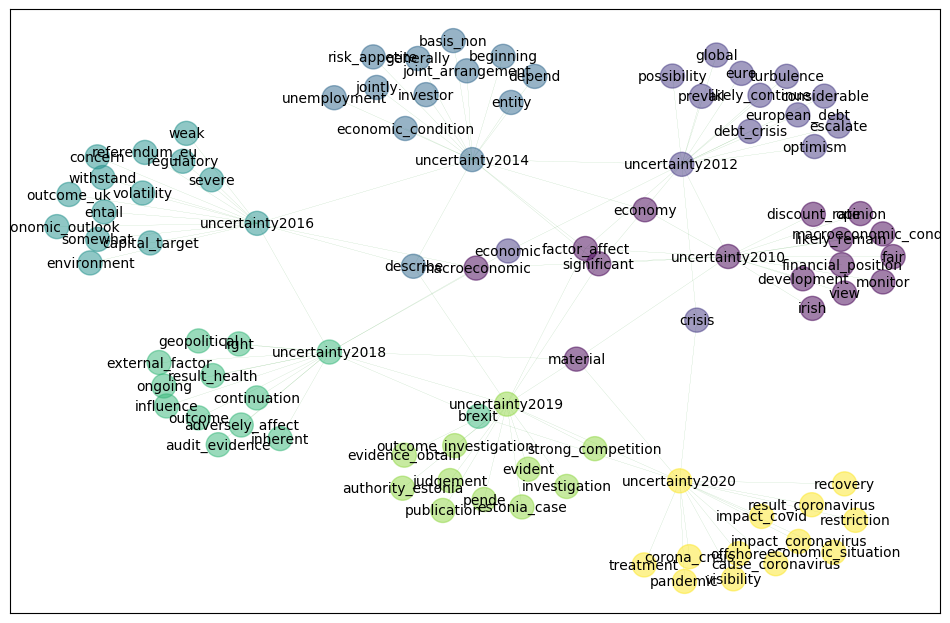

In [46]:
#%matplotlib qt 

g.plot()